In [30]:
# 📌 Step 0: 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.preprocessing import  OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score, f1_score

In [59]:
# 📌 Step 1: 데이터 로드
train = pd.read_csv("C:/Users/yoony/Downloads/open/train.csv").drop(columns=['ID'], errors='ignore')
test = pd.read_csv("C:/Users/yoony/Downloads/open/test.csv").drop(columns=['ID'], errors='ignore')

In [62]:
# 📌 Step 2: Emax 모델 함수 정의
def emax_model(x, emax, ec50, n):
    return emax * (x ** n) / (x ** n + ec50 ** n)

In [63]:
# Emax 모델 적용할 변수 선택 (임신 시도 경과 연수)
x_data = train["임신 시도 또는 마지막 임신 경과 연수"].values
y_data = train["임신 성공 여부"].values

In [64]:
# 결측값 제거 후 Emax 모델 피팅
valid_idx = ~np.isnan(x_data)
x_data = x_data[valid_idx]
y_data = y_data[valid_idx]

popt, _ = curve_fit(emax_model, x_data, y_data, bounds=([0, 0, 0], [1, 100, 10]))

C:\ProgramData\anaconda3_64bit\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3_64bit\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3_64bit\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3_64bit\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3_64bit\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, *

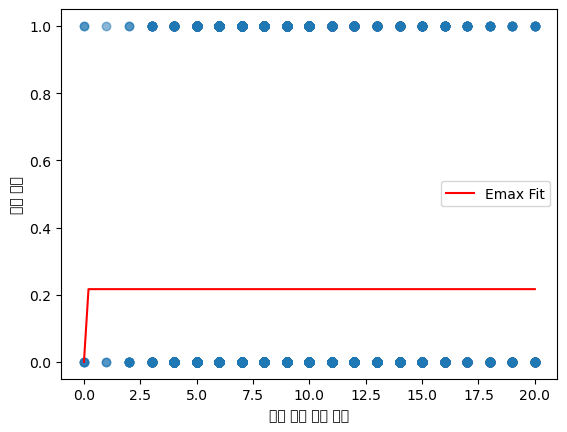

In [65]:
# 📌 Step 3: 피팅 결과 시각화
x_range = np.linspace(min(x_data), max(x_data), 100)
plt.scatter(x_data, y_data, alpha=0.3)
plt.plot(x_range, emax_model(x_range, *popt), color="red", label="Emax Fit")
plt.xlabel("임신 시도 경과 연수")
plt.ylabel("임신 확률")
plt.legend()
plt.show()

In [66]:
# 📌 Step 4: 데이터 전처리
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

In [67]:
# 범주형 변수 리스트
categorical_columns = [
    "시술 시기 코드", "시술 당시 나이", "시술 유형", "특정 시술 유형",
    "배란 자극 여부", "배란 유도 유형", "단일 배아 이식 여부", "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부", "남성 주 불임 원인", "남성 부 불임 원인", "여성 주 불임 원인",
    "여성 부 불임 원인", "부부 주 불임 원인", "부부 부 불임 원인", "불명확 불임 원인",
    "불임 원인 - 난관 질환", "불임 원인 - 남성 요인", "불임 원인 - 배란 장애", "불임 원인 - 여성 요인",
    "불임 원인 - 자궁경부 문제", "불임 원인 - 자궁내막증", "불임 원인 - 정자 농도", 
    "불임 원인 - 정자 면역학적 요인", "불임 원인 - 정자 운동성", "불임 원인 - 정자 형태",
    "배아 생성 주요 이유", "총 시술 횟수", "클리닉 내 총 시술 횟수", "IVF 시술 횟수", 
    "DI 시술 횟수", "총 임신 횟수", "IVF 임신 횟수", "DI 임신 횟수", "총 출산 횟수",
    "IVF 출산 횟수", "DI 출산 횟수", "난자 출처", "정자 출처", "난자 기증자 나이", 
    "정자 기증자 나이", "동결 배아 사용 여부", "신선 배아 사용 여부", "기증 배아 사용 여부", 
    "대리모 여부", "PGD 시술 여부", "PGS 시술 여부"
]

In [68]:
# 카테고리형 컬럼들을 문자열로 변환
for col in categorical_columns:
    X[col] = X[col].astype(str)
    test[col] = test[col].astype(str)

In [75]:
# Ordinal Encoding 적용
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_encoded = X.copy()
X_train_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

X_test_encoded = test.copy()
X_test_encoded[categorical_columns] = ordinal_encoder.transform(test[categorical_columns])

In [76]:
# 연속형 변수 결측값 처리
numeric_columns = [
    "임신 시도 또는 마지막 임신 경과 연수", "총 생성 배아 수", "미세주입된 난자 수", 
    "미세주입에서 생성된 배아 수", "이식된 배아 수", "미세주입 배아 이식 수", 
    "저장된 배아 수", "미세주입 후 저장된 배아 수", "해동된 배아 수", "해동 난자 수", 
    "수집된 신선 난자 수", "저장된 신선 난자 수", "혼합된 난자 수", "파트너 정자와 혼합된 난자 수", 
    "기증자 정자와 혼합된 난자 수", "난자 채취 경과일", "난자 해동 경과일", "난자 혼합 경과일", 
    "배아 이식 경과일", "배아 해동 경과일"
]

X_train_encoded[numeric_columns] = X_train_encoded[numeric_columns].fillna(0)
X_test_encoded[numeric_columns] = X_test_encoded[numeric_columns].fillna(0)

In [77]:
# 📌 Step 5: 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [78]:
# 📌 Step 6: 모델 학습 (ExtraTreesClassifier)
model = ExtraTreesClassifier(random_state=42)
model.fit(X_encoded, y)

ExtraTreesClassifier(random_state=42)

In [52]:
# 📌 Step 7: 모델 평가
y_pred = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)[:, 1]
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_prob):.4f}")
print(f"F1-score: {f1_score(y_val, y_pred):.4f}")

AUC-ROC: 1.0000
F1-score: 1.0000


In [79]:
# 📌 Step 8: 테스트 데이터 예측 및 제출 파일 생성
pred_proba = model.predict_proba(X_test_encoded)[:, 1]
sample_submission = pd.read_csv("C:/Users/yoony/Downloads/open/sample_submission.csv")
sample_submission['probability'] = pred_proba

In [82]:
sample_submission.to_csv('C:/Users/yoony/Downloads/open/baseline_submit.csv', index=False)

In [51]:
# 범주형 변수 및 연속형 변수 지정
cat_features = ["시술 시기 코드", "시술 당시 나이", "시술 유형", "특정 시술 유형"]
num_features = [col for col in X.columns if col not in cat_features]

In [18]:
# 숫자형 컬럼에 비숫자값이 있는지 확인
X[num_features].apply(pd.to_numeric, errors='coerce')

# 이 코드는 비숫자값을 NaN으로 변환합니다. 이후 NaN 값을 처리(예: 평균값으로 채우거나 행을 삭제 등)할 수 있습니다.
X[num_features] = X[num_features].apply(pd.to_numeric, errors='coerce')

C:\Users\yoony\AppData\Local\Temp\ipykernel_25244\3225479619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_features] = X[num_features].apply(pd.to_numeric, errors='coerce')


In [17]:
# 원-핫 인코딩 및 스케일링 적용
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X = preprocessor.fit_transform(X)
X_test = preprocessor.transform(X_test)

ValueError: could not convert string to float: '기록되지 않은 시행'